## 1) **Task and Data description** <a id="description"></a> 

Since real predictive maintenance datasets are generally difficult to obtain and in particular
difficult to publish, the data provided by the UCI repository is a synthetic dataset that reflects
real predictive maintenance encountered in industry to the best of their knowledge.
The dataset consists of 10 000 data points stored as rows with 14 features in columns:
* UID: unique identifier ranging from 1 to 10000;
* Product ID: consisting of a letter L, M, or H for low (60% of all products), medium (30%)
and high (10%) as product quality variants and a variant-specific serial number;
* Air temperature [K]: generated using a random walk process later normalized to a standard
deviation of 2 K around 300 K;
* Process temperature [K]: generated using a random walk process normalized to a standard
deviation of 1 K, added to the air temperature plus 10 K;
* Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally
distributed noise;
* Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation
of 10 Nm and no negative values;
* Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used
tool in the process;
* Machine failure: label that indicates, whether the machine has failed in this particular data
point for any of the following failure modes are true.
The machine failure consists of five independent failure modes:
* tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear
time between 200 - 240 mins;
* heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference
between air- and process temperature is below 8.6 K and the tools rotational speed is below
1380 rpm;

* power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power
required for the process. If this power is below 3500 W or above 9000 W, the process fails;
* overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for
the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
* random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process
parameters.
If at least one of the above failure modes is true, the process fails and the ’machine failure’
label is set to 1. It is therefore not transparent to the machine learning method, which of the
failure modes has caused the process to fail.

## 2) **Exploratory Analysis** <a id="EDA"></a>
Our data exploration starts by checking that each entry is unique and there are no duplicates;
this is done by veryfing that the number of unique ProductID corresponds to the number of
observations. Then we print a report to look for missing values and check the data type for each
column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import data
data_path = '../input/machine-predictive-maintenance-classification/predictive_maintenance.csv'
data = pd.read_csv(data_path)
n = data.shape[0]
# First checks
print('Features non-null values and data type:')
data.info()
print('Check for duplicate values:',
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Check for duplicate values: False


To sum up even more:
* There is no missing data;
* There are no duplicate values;
* Six columns are numerical features, including UDI;
* Three columns are categorical features, including ProductID.

To make this distinction more clear we set numeric columns to float type.

In [2]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

### 2.1) ID Columns <a id="ID"></a>
Before going into more technical matters we deal with the two ID columns as the model we will
use could get confused by them, since it is unrealistic to think that the failure of a machine
depends on its identifier. However, while UDI results in being a copy of the dataframe index,
the column Product ID is made up of an initial letter followed by five numbers; there is a small
chance that an hidden pattern lies behind this structure. However, the initial letter corresponds
to the machine Type and the number sequences define three intervals based on the same feature;
this allows to confirm that the Product ID column does not actually carry any more information
than the feature Type and it is legit to drop it.
The following histogram shows the number sequences:

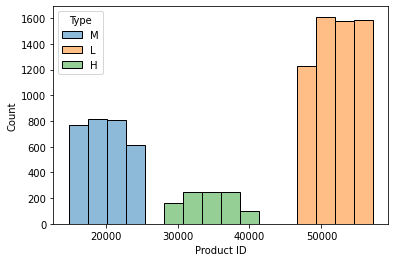

In [3]:
# Remove first character and set to numeric dtype
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

# Histogram of ProductID
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()

In [4]:
# Drop ID columns
df = data.copy()
df.drop(columns=['UDI','Product ID'], inplace=True)

The following pie chart shows the percentages of machines by Type:

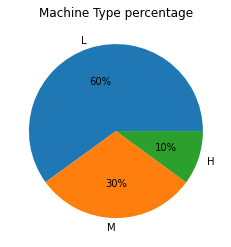

In [5]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

### 2.2) Target anomalies <a id="target"></a>

In this section we observe the distribution of the target to find any imbalances and correct them
before dividing the dataset.
The first anomaly respect to dataset’s description is that when the failure is random (RNF), the
Machine Failure feature is not set to 1.

In [6]:
# Create lists of features and target names
features = [col for col in df.columns
            if df[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
df.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


Fortunately the machine failure RNF occurs in only 18 observations and it has a random nature
therefore not predictable so we decide to remove these rows.

In [7]:
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


Going forward we find out that in 9 observations Machine failure is set to 1 when all types
of failures are set to 0. We cannot understand if there really was a failure or not so let’s remove
these observations too.

In [8]:
# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [9]:
# Global percentage of removed observations
print('Global percentage of removed observations:',
     (100*(first_drop+second_drop)/n))
df.reset_index(drop=True, inplace=True)   # Reset index
n = df.shape[0]

Global percentage of removed observations: 0.27


Our actions did not alterate the original data very much.

### 2.3) Outliers inspection <a id="outliers"></a>

The goal of this section is to check if the dataset contains any outlier, which are usually misleading
for machine learning algorithms. We begin by looking at a statistical report of the numerical
features.

In [10]:
df.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


We can guess the presence of outliers in Rotational Speed and Torque because the maximum is
very different from the third quartile. To make this consideration more concrete we take a closer
look at the situation with boxplots, using histograms to understand the distribution.

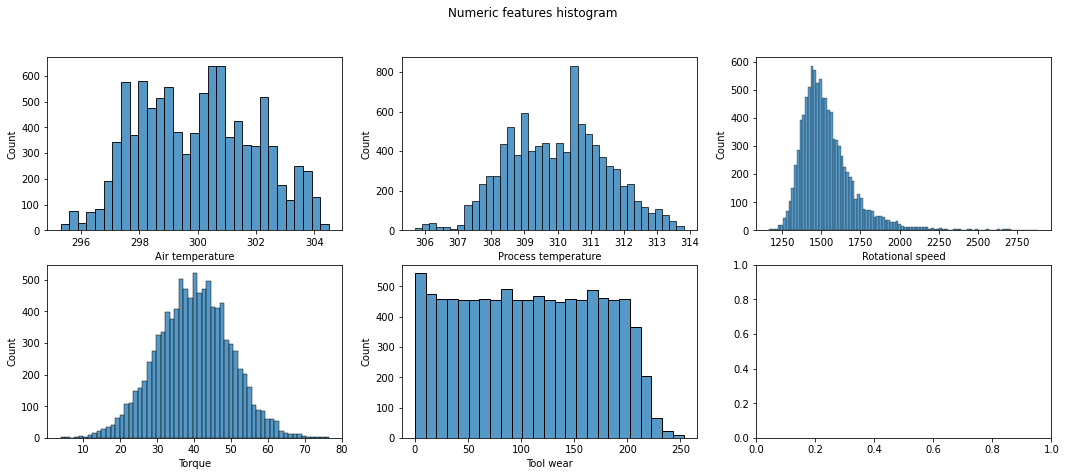

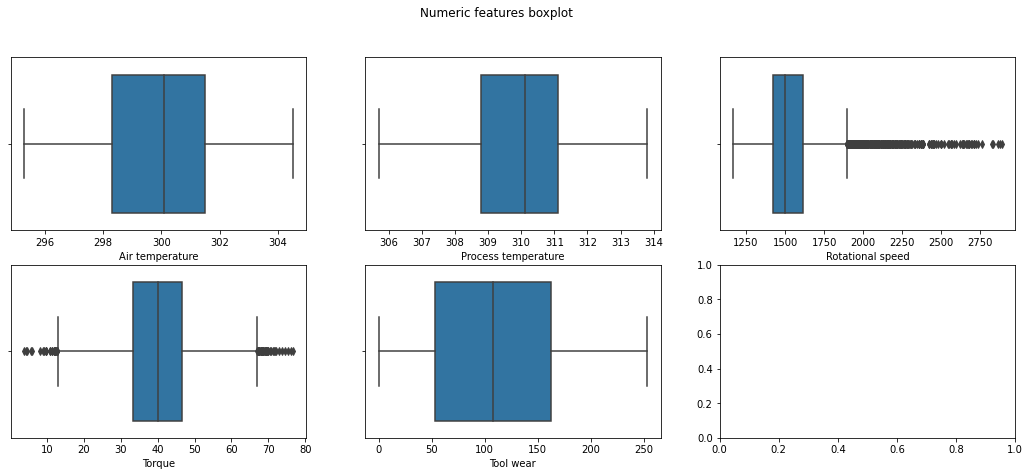

In [11]:
num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

The boxplots highlight possible outliers in the features mentioned above, however in the case
of Torque these are probably traceable to the way outliers are detected using boxplots (since the
distribution is Gaussian it would be more appropriate to use the 3σ rule instead of the IQR); in
the case of Rotational Speed the Gaussian distribution is skewed and it is not unrealistic to think
that the few observation with high Rotational Speed are going to fail. As a result we keep the
outliers for now and we reserve the right to decide whether to act on them or not after considering
other aspects.

### 2.4) Resampling with SMOTE <a id="resampling"></a>

Another important consideration regards the extremely low occurrence of machine failures among
the entire dataset, which percentage is equal only to 3.31%. Moreover, a pie plot showing the
occurrence of the causes involved for each failure reveals a further degree of imbalance.

Failures percentage in data: 3.31


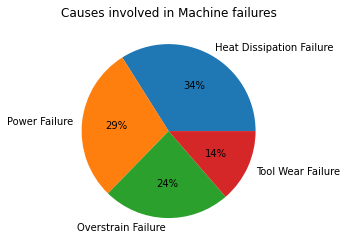

In [12]:
# Portion of df where there is a failure and causes percentage
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

When dealing with machine learning problems classes imbalance is a great concern, as it can
mislead both the models training process and our ability to interpret their results. As instance,
if we build a model on this dataset that predicts that machines never fail, it should be 97%
accurate. In order to avoid such effects and limit the preferential behaviour of the models with
respect to individual classes we perform a data augmentation, with the aim of obtaining a ratio
of 80 to 20 between functioning and faulty observations and the same percentage of occurrence
between the causes involved in the failures.

Among the most common data augmentation techniques we identify:
* Under-sampling by deleting some data points from the majority class.
* Over-Sampling by copying rows of data resulting in the minority class.
* Over-Sampling with SMOTE (Synthetic Minority Oversampling Technique).

The first two choices however result in extremely simplistic approaches; in particular the first one
has the disadvantage of decreasing the length of the dataset in a context in which the available
data are already limited. Therefore we use the SMOTE procedure to generate new samples,
which is very much like slightly moving the data point in the direction of its neighbors. This way,
the synthetic data point is not an exact copy of an existing data point but we can also be sure
that it is also not too different from the known observations in the minority class. To be more
precise, the SMOTE procedure works as follows: it draws a random sample from the minority class and for the observations in this sample, identifies the k nearest neighbors. It will then take
one of those neighbors and identify the vector between the current data point and the selected
neighbor. The vector will be multiplied by a random number between 0 and 1 and the synthetic
data point is obtained by adding this vector to the current data point.

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
# n_working must represent 80% of the desired length of resampled dataframe
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

### 2.5) Comparison after resampling <a id="resample_comparison"></a>

The result is described in the following pie charts.

Percentage increment of observations after oversampling: 20.88
SMOTE Resampled Failures percentage: 20.01


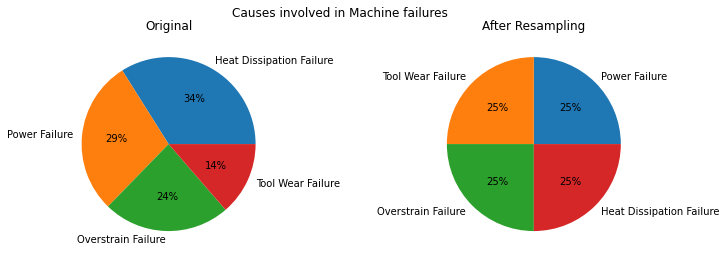

In [14]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

As one can expect, the cases of Machine Failure mainly concern low quality machines, then
those of medium quality and only a few times those of high quality. This difference is accentuated
when the number of observations of non-functioning machines is (artificially) increased. However,
from the kdeplots below it can be seen that this is not widely correlated with the features since
differentiating according to the quality shows that distribution of the features does not present
big differences, except for the two side peaks in Tool Wear (which is consistent with the data
description). This suggests that probably the fact that the majority of failures concern type
L machines is due to the greater presence of this type in the dataset and therefore that the
correlation with the failure of the machine is due to statistical reasons.

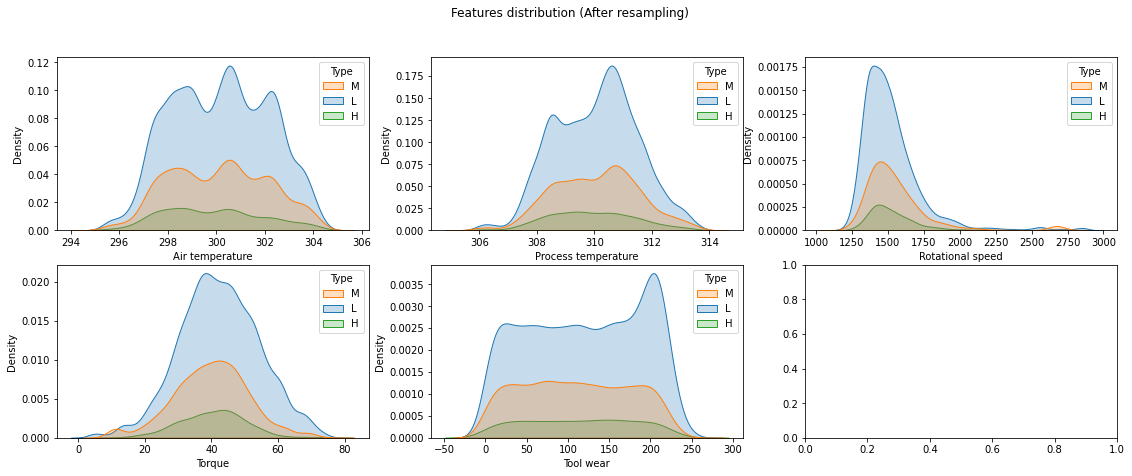

In [15]:
# Kdeplot of numeric features (After resampling) - hue=Type
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,7))
fig.suptitle('Features distribution (After resampling)')
custom_palette = {'L':'tab:blue', 'M':'tab:orange', 'H':'tab:green'}
for j, feature in enumerate(num_features):
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
              hue='Type', fill=True, palette=custom_palette)
plt.show()

Finally, let’s look at how the distribution of features has changed.

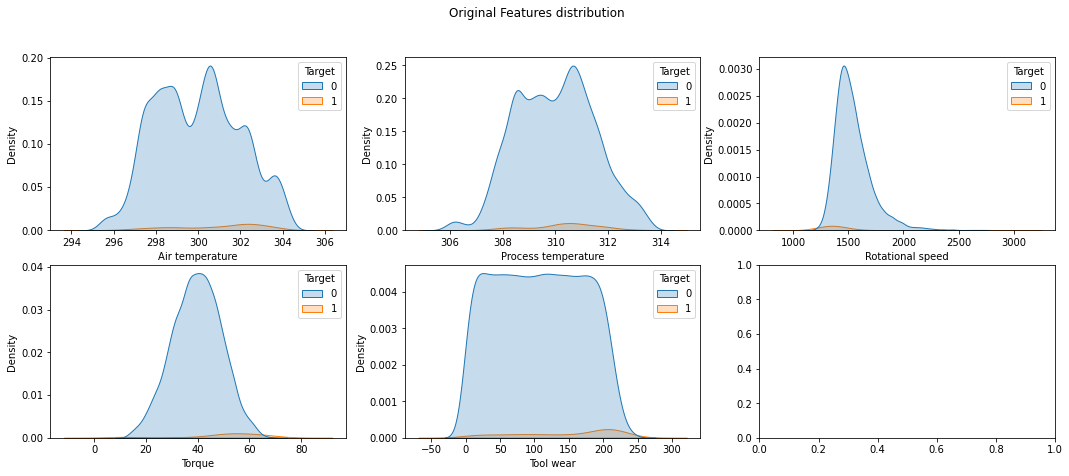

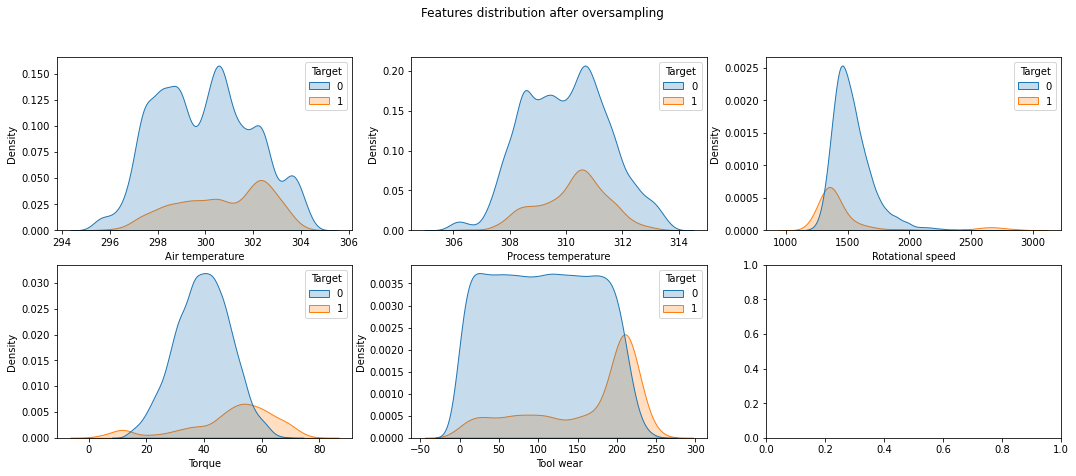

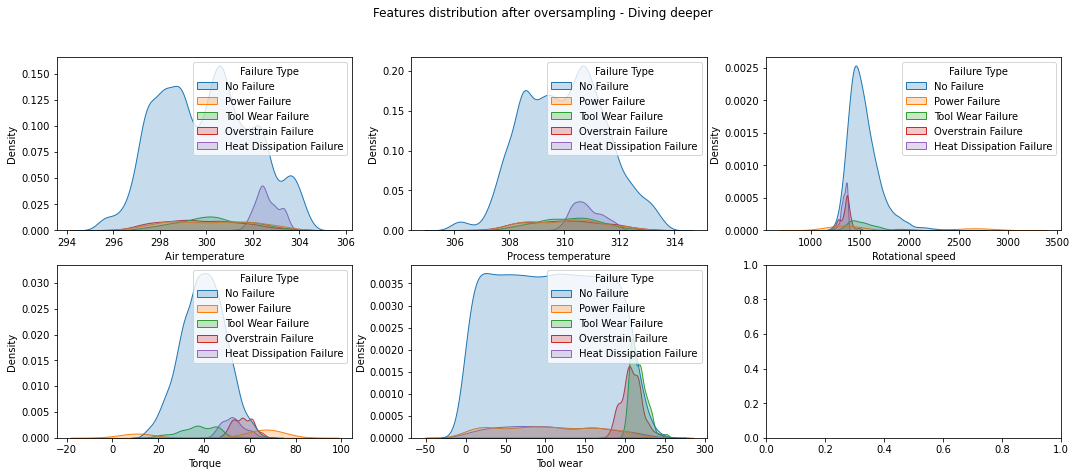

In [16]:
# Kdeplot of numeric features (Original)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Original Features distribution')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature,
                hue='Target', fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Target'], fill=True, palette='tab10')
plt.show()
# Kdeplot of numeric features (After resampling) - Diving deeper
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Features distribution after oversampling - Diving deeper')
enumerate_features = enumerate(num_features)
for j, feature in enumerate_features:
    sns.kdeplot(ax=axs[j//3, j-3*(j//3)], data=df_res, x=feature,
                hue=df_res['Failure Type'], fill=True, palette='tab10')
plt.show()

The first thing we can observe is that the data augmentation was performed succesfully, as the
feature distribution for faulty instancies have not been significantly distorted. It should also be
noted that in Rotational Speed, Torque and Tool Wear the observations relating to failures have
a density peak in extreme zones of the distribution. This implies that the outliers we discussed
in Section 2.3 are not to be imputed to mistakes in the dataset building but rather to the natural
variance of the same. This becomes even clearer when observing the distributions relative to the
single causes of failure: in particular, an almost symmetrical behavior is recognized in Rotational
Speed and Torque while in Tool Wear a clear separation is observed between PWF and HDF
failures on lower values, and the peaks that are found at higher values relative to TWF and OSF.
This is perfectly consistent with the description of the targets reported in the "Task and dataset
description" section.

### 2.6) Features scaling and Encoding <a id="encoding"></a>

In order to make data exploitable for the algorithms we will run, we apply two transformations:
* First, we apply a label encoding to the categorical columns, since Type is an ordinal feature
and Cause must be represented in one column. The mapping follows this scheme:
Type: {L=0, M=1, H=2}
Cause: {Working=0, PWF=1, OSF=2, HDF=3, TWF=4}
* Secondly we perform the scaling of the columns with StandardScaler. This is particularly
useful for the good working of methods that rely on the metric space, such as PCA and KNN.
It has been also verified that using StandardScaler leads to slightly better performances than
using MinMaxScaler.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}
df_pre = df_res.copy()
# Encoding
df_pre['Type'].replace(to_replace=type_dict, inplace=True)
df_pre['Failure Type'].replace(to_replace=cause_dict, inplace=True)
# Scaling
df_pre[num_features] = sc.fit_transform(df_pre[num_features]) 

### 2.7) PCA and Correlation Heatmap <a id="pca"></a>

We run PCA to have a further way of displaying the data instead of making feature selection.

In [18]:
pca = PCA(n_components=len(num_features))
X_pca = pd.DataFrame(data=pca.fit_transform(df_pre[num_features]), columns=['PC'+str(i+1) for i in range(len(num_features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(num_features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 3 components: '+str(round(var_exp.values[:3].sum(),2)))

Explained variance ratio per component:
PC1    37.69
PC2    36.81
PC3    19.84
PC4     3.08
PC5     2.58
dtype: float64
Explained variance ratio with 3 components: 94.34


Since the first three components are enough to almost fully represent the variance of the data
we will project them in a three dimensional space.

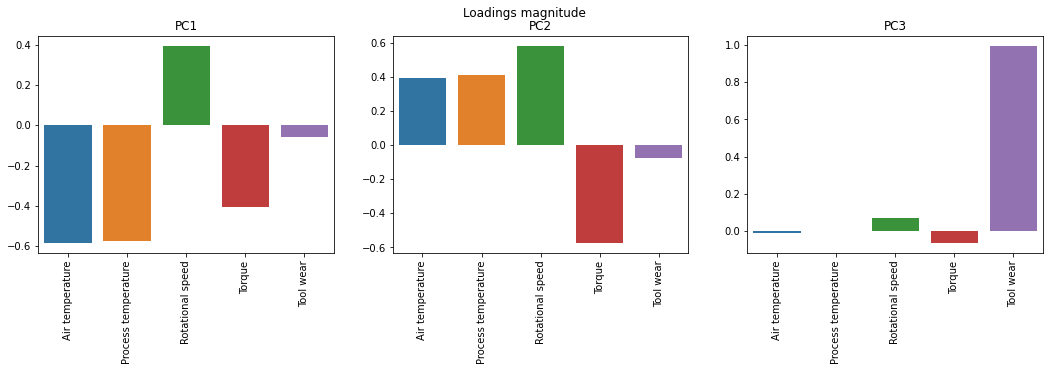

In [19]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(df_pre[num_features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=num_features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()  

The bar plot of Principal Components weights makes easy to understand what they represent:
* PC1 is closely related to the two temperature data;
* PC2 can be identified with the machine power, which is the product of Rotational Speed
and Torque;
* PC3 is identifiable with Tool Wear.

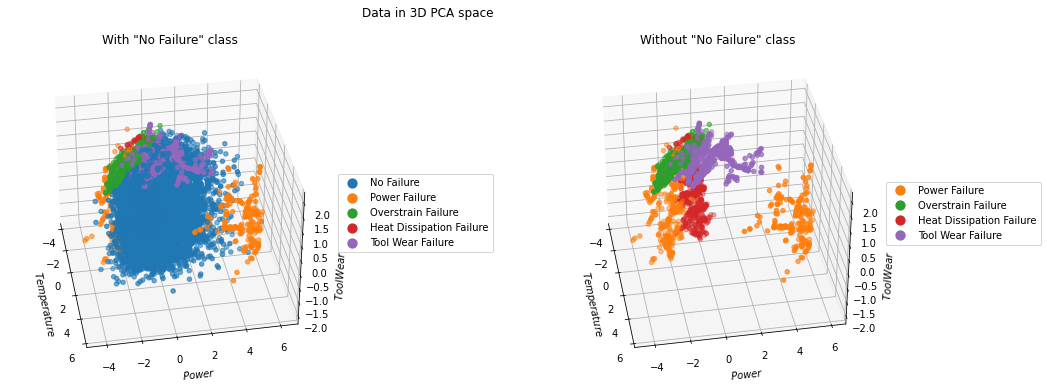

In [20]:
X_pca3.rename(mapper={'PC1':'Temperature',
                      'PC2':'Power',
                      'PC3':'Tool Wear'}, axis=1, inplace=True)

# PCA plot
color = []
col = df_pre['Failure Type'].map({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'tab:purple'})
color.append(col)
idx_w = col[col == 'tab:blue'].index
color.append(col.drop(idx_w))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
labelTups = [('No Failure','tab:blue'),
             ('Power Failure', 'tab:orange'),
             ('Overstrain Failure','tab:green'),
             ('Heat Dissipation Failure', 'tab:red'),
             ('Tool Wear Failure','tab:purple')]

fig = plt.figure(figsize=(18,6))
fig.suptitle('Data in 3D PCA space')
full_idx = X_pca3.index

for j, idx in enumerate([full_idx,idx_fail_res]):
    ax = fig.add_subplot(1, 2, j+1, projection='3d')

    lg = ax.scatter(X_pca3.loc[idx,'Temperature'],
                    X_pca3.loc[idx,'Power'],
                    X_pca3.loc[idx,'Tool Wear'],
                    c=color[j])
    ax.set_xlabel('$Temperature$')
    ax.set_ylabel('$Power$')
    ax.set_zlabel('$Tool Wear$')
    ax.title.set_text('With'+str(j*'out')+' "No Failure" class')
    ax.view_init(35, -10) 
    custom_lines = [plt.Line2D([],[], ls="", marker='.', 
                               mec='k', mfc=c, mew=.1, ms=20) for c in colors[j:]]
    ax.legend(custom_lines, [lt[0] for lt in labelTups[j:]], 
              loc='center left', bbox_to_anchor=(1.0, .5))
      
plt.show()

The projection into the space generated by these three axes highlights that:
* TWF is the class of failures best separated from all the others and seems to depend almost
entirely on PC3 (Tool Wear);
* PWF occupies two extreme bands along the PC2 (Power), it is independent of the other
two components;
18
* The OSF and HDF classes are less separated than the others even if it can be observed
that the first is characterized by a high Tool Wear and low power while the second is
characterized by a high temperature and a low power.

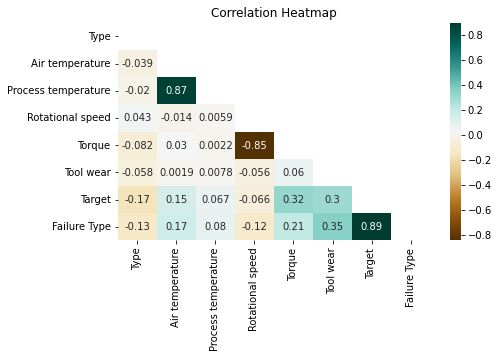

In [21]:
# Correlation Heatmap
plt.figure(figsize=(7,4))
sns.heatmap(data=df_pre.corr(), mask=np.triu(df_pre.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

Unsurprisingly, we observe that the features related to temperature, as well as those related to
power, are widely correlated. Furthermore, Tool Wear correlates well with both of our targets,
confirming what we have observed by studying PCA. Finally, a less strong correlation is also
observed between the torsion and the two targets.

### 2.8) Metrics <a id="metrics"></a>

To evaluate the models we will use from a quantitative point of view, we resort to some metrics
that summarize some characteristics of the classification results:
* Accuracy: expresses the fraction of instances that are classified correctly, it is the most intuitive metric that is usually used in classification tasks.
$$ Accuracy = \frac{TP + TN}{TP + TN + FT + FN} $$
* AUC: can be considered as a measure of the separation between True Positives and True Negatives, that is, the ability of the model to distinguish between classes. In detail, it represents the area below the ROC curve, given by the estimate of the True Positive Rate (Recall) for each possible value of the True Negative Rate).
* F1: reports the classification capacity of the model to Precision and Recall, giving both the same weight.
$$F1 = 2\frac{Precision * Recall}{Precision + Recall}$$
Although generally effective, AUC can be optimistic in the case of highly unbalanced
classes, as happens in the binary task, while the F1 score is more reliable in this kind of scenario.
We consider this last metric particularly significant as it is able to mediate the cases in which
the machines that are about to fail are classified as functioning (Recall) and the one in which
functioning machines are classified as about to suffer a failure (Precision). To be more specific
we will give more importance to Recall than Precision, by evaluating also an "adjusted" version
of the F1 through a β parameter:
$$F_\beta = (1 + \beta^2)\frac{Precision * Recall}{\beta^2  Precision + Recall}$$
With the choice $\beta = 2$ (common in literature) a greater influence of the Recall is obtained.
This choice is motivated by the fact that in order to optimize the costs for the maintenance of
the machinery it is a good thing to limit the purchase of unnecessary replacement materials but
it results far more important to avoid the possibility of having to replace a machinery after it is
broken, since this second scenario generally has higher costs.

## 3) **Binary task** <a id="binary"></a> 

### 3.1) Preliminaries <a id="preliminaries"></a>

The goal of this section is to find the best model for binary classification of the dataset to predict whether or not there will be Machine Failure. Classification algorithms are part of data mining and use supervised machine learning methods to make predictions about data. In particular, a
set of data already divided (”labeled”) into two or more classes of belonging is provided as input
thanks to which a classification model is created, which will than be used on new (”unlabeled”)
data to assign them to the appropriate class. The starting dataset is usually divided into three
groups: the training dataset, i.e. the sample of data used to fit the model, the validation dataset,
i.e. the sample of data used to provide an evaluation of a model fit on the training dataset while
tuning model hyperparameters and the test dataset, which has the purpose of testing the model.
At the beginning of a project a data scientist must make this division and the common ratios
used are:
* 70% train, 15% val, 15% test.
* 80% train, 10% val, 10% test.
* 60% train, 20% val, 20% test.

In this project we use the ratio (80/10/10) for the split because we test the model for all of these
strategies and find that it is the best one.
The classification techniques we choose to implement are the following:
* Logistic Regression: it estimates the probability of a dependent variable as a function
of independent variables. The dependent variable is the output that we are trying to
predict while the independent variables or explanatory variables are the factors that we
feel could influence the output. For its simplicity and interpretability, we decide to use
Logistic Regression as a Benchmark model, a basic model that represents the starting point
for comparing the results obtained from other models.
* K-nearest neighbors (K-NN): algorithm based on the calculation of the distance between the elements of the dataset. Data is assigned to a certain class if close enough to the other data of the same class. Parameter K represents the number of neighboring data taken into account when assigning classes.
* Support Vector Machine: its aim is to find a hyperplane in an N-dimensional space (N—the number of features) that distinctly classifies the data points while maximizing the margin distance, i.e. the distance between data points of both classes.
* Random Forest: it uses ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. Random Forest uses bagging technique: it constructs a multitude of decision trees in parallel, all with the same importance, and the output is the class selected by most trees.
* XGBoost: is a gradient-boosted decision tree (GBDT) machine learning library. A Gradient Boosting Decision Tree (GBDT) is a decision tree ensemble learning algorithm similar to Random Forest, from which differs because it uses a boosting technique: it iteratively trains an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions.

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

# train-validation-test split
X, y = df_pre[features], df_pre[['Target','Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df_pre['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

We define some functions to make the following subsections easier to read. If not interested in the details we suggest to skip to Section 3.1

In [23]:
"""User-defined function: Evaluate cm, accurcay, AUC, F1 for a given classifier
- model, fitted estimator.
- X, data used to estimate class probabilities (paired with y_true)
- y_true, ground truth with two columns
- y_pred, predictions
- task = 'binary','multi_class'
"""
def eval_preds(model,X,y_true,y_pred,task):
    if task == 'binary':
        # Extract task target
        y_true = y_true['Target']
        cm = confusion_matrix(y_true, y_pred)
        # Probability of the minority class
        proba = model.predict_proba(X)[:,1]
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
    elif task == 'multi_class':
        y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics



"""User-defined function: Fits one estimator using GridSearch to search for the best parameters
- clf, estimator
- X, y = X_train, y_train
- params, parameters grid for GridSearch
- task = 'binary','multi_class'
"""
def tune_and_fit(clf,X,y,params,task):
    if task=='binary':
        f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                                cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Target'])
    elif task=='multi_class':
        f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
        start_time = time.time()
        grid_model = GridSearchCV(clf, param_grid=params,
                              cv=5, scoring=f2_scorer)
        grid_model.fit(X, y['Failure Type'])
        
    print('Best params:', grid_model.best_params_)
    # Print training times
    train_time = time.time()-start_time
    mins = int(train_time//60)
    print('Training time: '+str(mins)+'m '+str(round(train_time-mins*60))+'s')
    return grid_model



"""User-defined function: Makes predictions using the tuned classifiers.
Then uses eval_preds to compute the relative metrics. Returns:
- y_pred, DataFrame containing the predictions of each model
- cm_list, confusion matrix list
- metrics, DataFrame containing the metrics
Input:
- fitted_models, fitted estimators
- X, data used to make predictions
- y_true, true values for target
- clf_str, list containing estimators names
- task = 'binary','multi_class'
"""
def predict_and_evaluate(fitted_models,X,y_true,clf_str,task):
    cm_dict = {key: np.nan for key in clf_str}
    metrics = pd.DataFrame(columns=clf_str)
    y_pred = pd.DataFrame(columns=clf_str)
    for fit_model, model_name in zip(fitted_models,clf_str):
        # Update predictions
        y_pred[model_name] = fit_model.predict(X)
        # Metrics
        if task == 'binary':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        elif task == 'multi_class':
            cm, scores = eval_preds(fit_model,X,y_true,
                                     y_pred[model_name],task)
        # Update Confusion matrix and metrics
        cm_dict[model_name] = cm
        metrics[model_name] = scores
    return y_pred, cm_dict, metrics



"""User-defined function: Fit the estimators on multiple classifiers
- clf, estimators
- clf_str, list containing estimators names
- X_train,y_train, data used to fit models
- X_val,y_val, data used to validate models
"""

def fit_models(clf,clf_str,X_train,X_val,y_train,y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train,y_train['Target'])
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model,X_val,y_val,y_val_pred,'binary')[1]
    return metrics

### 3.2) Feature selection attempts <a id="selection"></a>

Before going into the training of the models just mentioned we try to perform feature selection,
exploiting the considerations we made about the correlation heatmap and the exploratory data
analysis: just to remind, we noticed that the features "Process temperature" and "Air temperature"
are positively correlated, and "Torque" and "Rotational speed" are negatively correlated.
From the dateset description we see that the PWF failure occurs if the product between "Torque"
and "Rotational speed" is in a certain range of values and, similarly, HDF failure occurs when
the difference between "Air temperature" and "Process temperature" exceeds a certain value.
For these reasons, completely deleting these columns seems to be a bad choice because important
information can be lost but at the same time it is reasonable to see what happens if we combine
them, taken by pairs, to create new features that still preserve a physical meaning. Therefore we
proceed to compare the results obtained by fitting the classification models without tuning any
parameter on the following datasets:
* the original one;
* the one obtained by removing the "Process temperature" and "Air temperature" columns, replacing them with a column of their product;
* the one obtained by removing "Torque" and "Rotational speed", replacing them with a column of their product;
* a combine the previous operations.

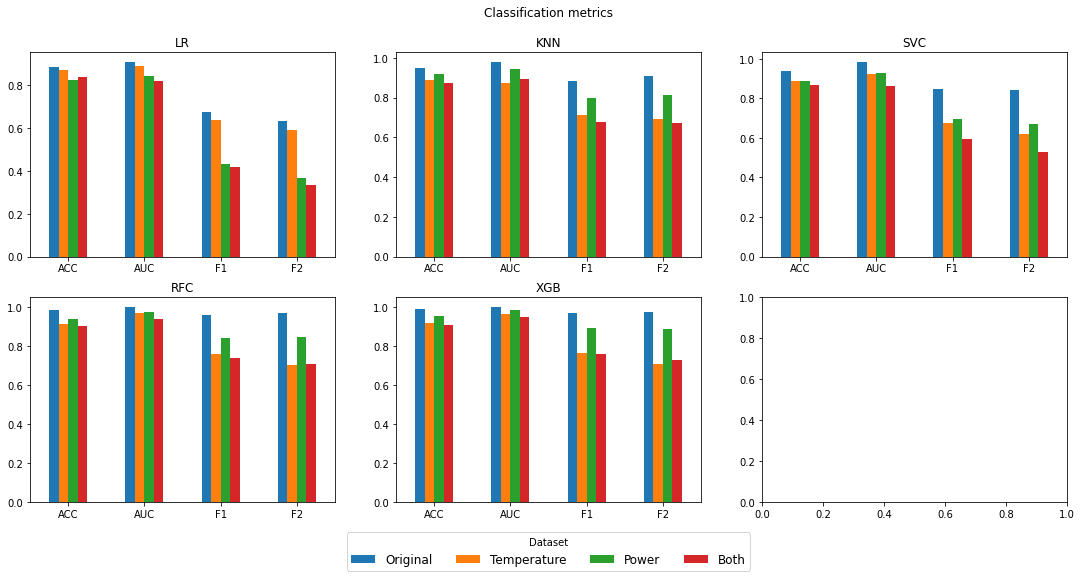

In [24]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

# Fit on raw train
metrics_0 = fit_models(clf,clf_str,X_train,X_val,y_train,y_val)

# Fit on temperature product train
XX_train = X_train.drop(columns=['Process temperature','Air temperature'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']-X_val['Air temperature']
metrics_1 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Rotational speed','Torque'])
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']     
metrics_2 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_val = X_val.drop(columns=['Process temperature','Air temperature','Rotational speed','Torque'])
XX_train['Temperature']= X_train['Process temperature']*X_train['Air temperature']
XX_val['Temperature']= X_val['Process temperature']*X_val['Air temperature']
XX_train['Power'] = X_train['Rotational speed']*X_train['Torque']
XX_val['Power'] = X_val['Rotational speed']*X_val['Torque']       
metrics_3 = fit_models(clf,clf_str,XX_train,XX_val,y_train,y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()

From the results obtained, we observe that all the models applied to the entire dataset perform
better than when they are applied to the ones created by reducing the number of features.
The best performances and the modest number of features from which our dataset is composed
encourage us to opt to avoid the feature selection step.

### 3.3) Logistic Regression Benchmark <a id="binary_benchmark"></a>

We decide to use Logistic Regression as a Benchmark for our task. It
represents an intermediate step between the basic model referred to in Section 2.4 and the more
complex models that we have described and we will explore in depth in the following sections.
Now we look at the results obtained and at the interpretability of the model.

Validation set metrics:
ACC    0.883
AUC    0.905
F1     0.673
F2     0.629
dtype: float64
Test set metrics:
ACC    0.881
AUC    0.917
F1     0.655
F2     0.598
dtype: float64


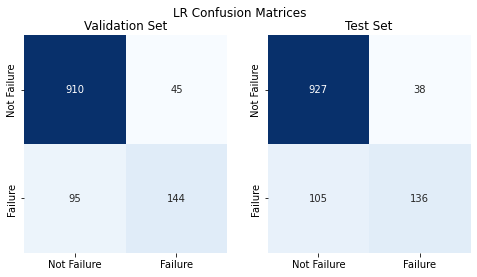

,feature,odds
4,Torque,16.696209
3,Rotational speed,9.394822
1,Air temperature,4.462500
5,Tool wear,3.483306
0,Type,0.520599
2,Process temperature,0.348815


In [25]:
# Make predictions
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train['Target'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'binary')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'binary')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_labels = ['Not Failure', 'Failure']
cm_lr = [cm_val_lr, cm_test_lr]
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
d = {'feature': X_train.columns, 'odds': np.exp(lr.coef_[0])}
odds_df = pd.DataFrame(data=d).sort_values(by='odds', ascending=False)
odds_df

The odds of logistic regression allow us to understand how the model is working. In particular,
an unrealistically high importance is given to Torque and Rotational Speed. This is mainly due
to the natural variance in these features, which is especially high when looking only at the failure
cases and tends to "deviate" the model. However it is reasonable to believe, on the basis of
exploratory analysis, that the first four features have a significantly greater relevance than the
last two. We also expect greater reliability of the odds values when we apply logistic regression to
the multiclass task, since the effects that are spread here appears to be localized around certain
types of failures.

### 3.4) Models <a id="binary_models"></a>


In [26]:
# Models
knn = KNeighborsClassifier()
svc = SVC()
rfc = RandomForestClassifier()
xgb = XGBClassifier() 
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

# Parameter grids for GridSearch
knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[300,500,700],
              'max_depth':[5,7],
              'learning_rate':[0.01,0.1],
              'objective':['binary:logistic']}
params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                   index=clf)

# Tune hyperparameters with GridSearch (estimated time 8m)
print('GridSearch start')
fitted_models_binary = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'binary')
    fitted_models_binary.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 3s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 1m 48s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 2m 55s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic'}
Training time: 2m 59s


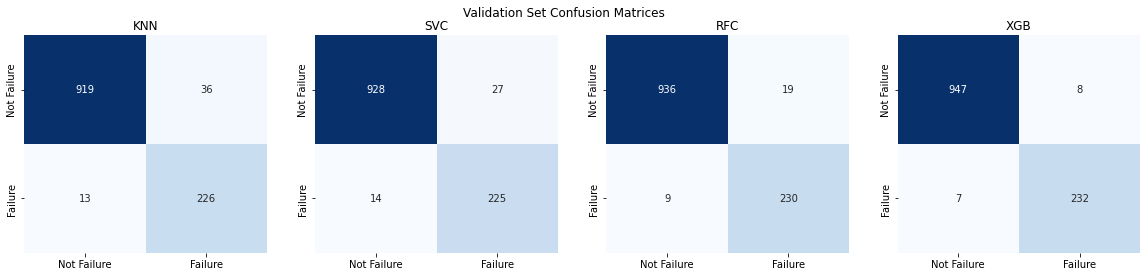

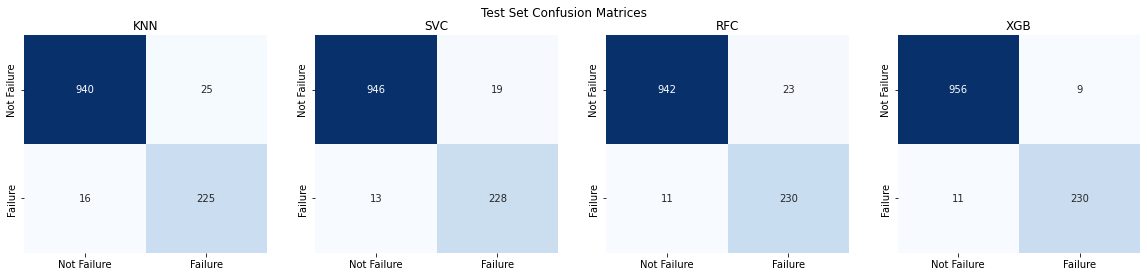


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.959  0.966  0.977  0.987
AUC  0.954  0.987  0.997  0.999
F1   0.902  0.916  0.943  0.969
F2   0.928  0.931  0.954  0.970
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.983
AUC  0.954  0.992  0.997  0.998
F1   0.916  0.934  0.931  0.958
F2   0.927  0.941  0.945  0.956


In [27]:
# Create evaluation metrics
task = 'binary'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_binary,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_binary,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

All the selected models obtain similar results on the validation set (except KNN which is a little
worse) and it is diffj7icult to determine if one works better than another by looking only at these
values. Performance did not significantly drop when passing the test set, showing that overfitting
was avoided. We comment on the results of the models by looking at the confusion matrices
and the metrics obtained on the test set: in this way the formation of a hierarchy between the
models used is slightly clearer, as all the metrics relating to a single model are smaller or larger
than to the others and the time needed to search for the parameters is comparable, with the only
exception of KNN. In particular KNN obtains the worst performances and XGB the best ones; in
the middle we find SVC and RFC which achieve extremely similar results.

About the parameters:
* A Gridsearch has been started on the parameters which, looking in the literature, appear to be preponderant for each specific model;
* The grid values to search for have been defined on the basis of literature and various tests, trying to keep the computational cost of finding the best values moderate.

It is interesting to observe that the optimal parameters for RFC and XGB are the polar
opposite: the former prefers to use a few estimators and go into depth while the latter uses more
estimators with fewer splits. Furthermore, it must be taken into account that although XGB
is the best classifier from a quantitative point of view, this is not true for what concerns the
qualitative side. Both SVC and XGB in fact lack clear ways to interpret the results, while on
the contrary RFC allows to have a complete understanding of how the algorithm worked. In
any case, to get an idea of which features had greater importance in making the predictions, we
report the permutation feature importances in a bar plot.

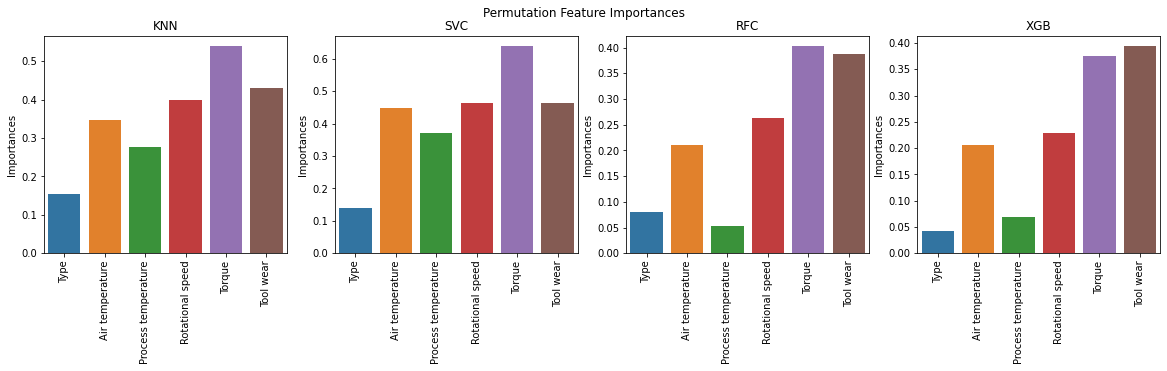

In [28]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
importances = pd.DataFrame()
for clf in fitted_models_binary:
    result = permutation_importance(clf, X_train,y_train['Target'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)
importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

Remarks on Feature importances:
* Type is the feature with the lowest significance, in accordance with what was observed during the exploratory analysis. However, its importance remains strictly positive in each of the cases considered and therefore removing it completely would have led to a decline in prediction performance, not justified by a significant computational gain;
* Unlike Logistic Regression, the models tested place great emphasis on Tool wear as well as Torque and Rotational Speed. Since the former alone is related to a specific category of failures and strongly distorts the kdeplot of Machine failure, we have a sign that our models still worked well.

## 4) **Multi-class task** <a id="multi"></a>
We now proceed to the second task of this project, that is predict not only if there will be a
failure, but also the type of failure that will occur. So we are in the case of multiclass classification problems that make the assumption that each sample is assigned to one and only one label. This hypothesis is verified because in data preprocessing we removed all the ambiguous observations that belonged to more than one class.

For multiclass targets, when we calculate the values of AUC, F1 and F2 scores, we need to set the
parameter "average". We choose "average=weighted", in order to account for class imbalance:
in fact, at the end of data preprocessing, we have 80% WORKING machine and 20% that fail.
As for binary classification task, we choose Logistic Regression as baseline model and we look for
models that get higher values for the chosen metrics. In particular, we adapt to the multiclass
case the models developed in the previous section. While many classification algorithms (such
as K-nearest neighbor, Random Forest and XGBoost) naturally permit the use of more than
two classes, some (like Logistic Regression and Support Vector Machines) are by nature binary
algorithms; these can, however, be turned into multiclass classifiers by a variety of strategies. For
our project, we decide to use "OnevsRest" approach, who involves training a single classifier per
class, with the samples of that class as positive samples and all other samples as negatives. We
choose it because it is computationally more efficient than other types of approach.

### 4.1) Logistic Regression Benchmark <a id="multi_benchmark"></a>
First let’s look at how the Logistic Regression behaves:

Validation set metrics:
ACC    0.926
AUC    0.983
F1     0.909
F2     0.919
dtype: float64
Test set metrics:
ACC    0.922
AUC    0.982
F1     0.904
F2     0.914
dtype: float64


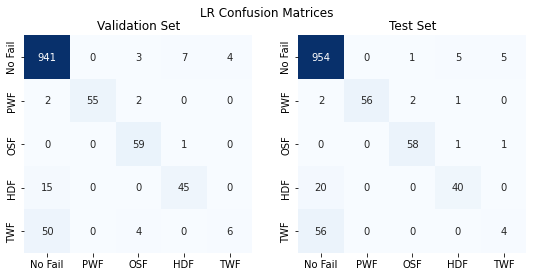

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
No Failure,1.920864,0.224090,2.866848,0.106442,0.059894,0.287084
Power Failure,0.697373,0.824558,0.982471,944.048373,2822.376842,0.744856
Tool Wear Failure,0.036806,0.215535,2.777322,0.108932,8.748803,406.189304
Overstrain Failure,0.636280,4314.687600,0.004253,0.000458,0.398540,0.711005
Heat Dissipation Failure,1.045501,1.337837,0.739732,0.225326,0.118551,749.948357


In [29]:
# multiclass classification
lr = LogisticRegression(random_state=0,multi_class='ovr')
lr.fit(X_train, y_train['Failure Type'])
y_val_lr = lr.predict(X_val)
y_test_lr = lr.predict(X_test)

# Validation metrics
cm_val_lr, metrics_val_lr = eval_preds(lr,X_val,y_val,y_val_lr,'multi_class')
cm_test_lr, metrics_test_lr = eval_preds(lr,X_test,y_test,y_test_lr,'multi_class')
print('Validation set metrics:',metrics_val_lr, sep='\n')
print('Test set metrics:',metrics_test_lr, sep='\n')

cm_lr = [cm_val_lr, cm_test_lr]
cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=2, figsize=(9,4))
fig.suptitle('LR Confusion Matrices')
for j, title in enumerate(['Validation Set', 'Test Set']):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_lr[j], annot=True,
              fmt='d', cmap='Blues', cbar=False)
    axs[j].title.set_text(title)
    axs[j].set_xticklabels(cm_labels)
    axs[j].set_yticklabels(cm_labels)
plt.show()

# Odds for interpretation
odds_df = pd.DataFrame(data = np.exp(lr.coef_), columns = X_train.columns,
                       index = df_res['Failure Type'].unique())
odds_df

In the table above there are, for every class, the Logistic Regression’s odds that
explain the contribution of each feature in the prediction of belonging to a specific class. By
comparing this table with the PCA scatter and the comments we made, we understand that there
is a complete agreement about the features that most affect the type of failure. For example, if
we look at odds’ values of PWF, we see that Rotational Speed and Torque are the ones that are
most important for the forecast of belonging to this class. In the analysis of the PCA we stated
that PWF seems to be dependent only on PC2, i.e. the Power that is the product of Rotational
Speed and Torque. We can make similar considerations for other classes.

### 4.2) Models <a id="multi_models"></a>
For each model we launch the Gridsearch for hyperparameter optimization, using as metric to
evaluate the model the weighted average F2 score. Similarly to the binary case, the Gridsearch
has been started on the parameters that, looking in the literature, are found to be preponderant
for each specific model and the grid values to look for have been defined according to the literature
and several tests carried out.

In [30]:
# Models
knn = KNeighborsClassifier()
svc = SVC(decision_function_shape='ovr')
rfc = RandomForestClassifier()
xgb = XGBClassifier()
clf = [knn,svc,rfc,xgb]
clf_str = ['KNN','SVC','RFC','XGB']

knn_params = {'n_neighbors':[1,3,5,8,10]}
svc_params = {'C': [1, 10, 100],
              'gamma': [0.1,1],
              'kernel': ['rbf'],
              'probability':[True],
              'random_state':[0]}
rfc_params = {'n_estimators':[100,300,500,700],
              'max_depth':[5,7,10],
              'random_state':[0]}
xgb_params = {'n_estimators':[100,300,500],
              'max_depth':[5,7,10],
              'learning_rate':[0.01,0.1],
              'objective':['multi:softprob']}

params = pd.Series(data=[knn_params,svc_params,rfc_params,xgb_params],
                    index=clf)


# Tune hyperparameters with GridSearch (estimated time 8-10m)
print('GridSearch start')
fitted_models_multi = []
for model, model_name in zip(clf, clf_str):
    print('Training '+str(model_name))
    fit_model = tune_and_fit(model,X_train,y_train,params[model],'multi_class')
    fitted_models_multi.append(fit_model)

GridSearch start
Training KNN
Best params: {'n_neighbors': 1}
Training time: 0m 2s
Training SVC
Best params: {'C': 100, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 0}
Training time: 2m 5s
Training RFC
Best params: {'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Training time: 2m 58s
Training XGB
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'multi:softprob'}
Training time: 8m 3s


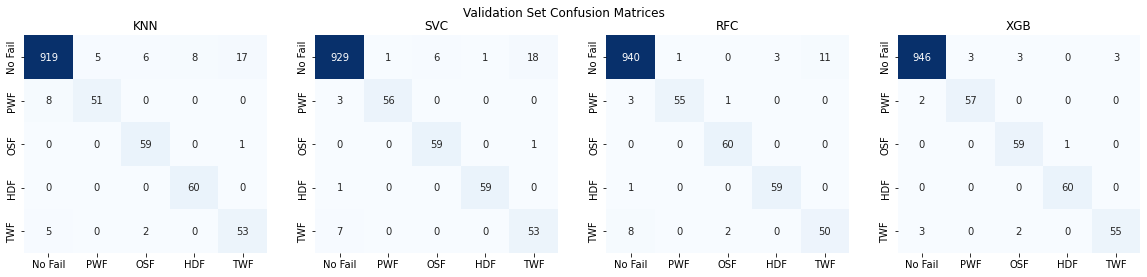

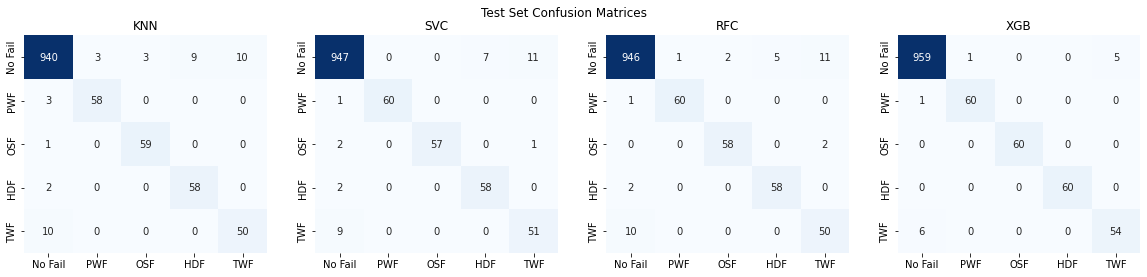


Validation scores:
       KNN    SVC    RFC    XGB
ACC  0.956  0.968  0.975  0.986
AUC  0.956  0.993  0.998  0.999
F1   0.957  0.969  0.975  0.986
F2   0.957  0.968  0.975  0.986
Test scores:
       KNN    SVC    RFC    XGB
ACC  0.966  0.973  0.972  0.989
AUC  0.956  0.995  0.997  0.999
F1   0.966  0.973  0.972  0.989
F2   0.966  0.973  0.972  0.989


In [31]:
# Create evaluation metrics

task = 'multi_class'
y_pred_val, cm_dict_val, metrics_val = predict_and_evaluate(
    fitted_models_multi,X_val,y_val,clf_str,task)
y_pred_test, cm_dict_test, metrics_test = predict_and_evaluate(
    fitted_models_multi,X_test,y_test,clf_str,task)

# Show Validation Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Validation Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_val[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Show Test Confusion Matrices
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Test Set Confusion Matrices')
for j, model_name in enumerate(clf_str):
    ax = axs[j]
    sns.heatmap(ax=ax, data=cm_dict_test[model_name], annot=True,
                fmt='d', cmap='Blues', cbar=False)
    ax.title.set_text(model_name)
    ax.set_xticklabels(cm_labels)
    ax.set_yticklabels(cm_labels)
plt.show()

# Print scores
print('')
print('Validation scores:', metrics_val, sep='\n')
print('Test scores:', metrics_test, sep='\n')

By comparing the results obtained, we see that K-NN is the model that performs the worst and
its accuracy is a little lower than Logistic Regression’s one. Despite this, we cannot exclude it a priori, as it still reaches high values for the metrics and, moreover, gives an immediate response.
So, we can use it whenever we need to get an idea quickly about the situation and, then apply
other models when we have more time.

All other models perform better than the benchmark and they obtain high values for the chosen
metrics both for validation and test set.
SVC and RFC’s performances are very similar each other and XGB performs better than them.
If we look at the training phase, SVC and RFC take the same time, while XGB takes more than
four times as much as them. So, since, the improvement obtained with XGB is only 1.5%, one
can choose which model he prefers according to his needs.
While the best parameters for multiclass K-NN and SVC are the same as binary classification, for
XGB and RFC the Gridsearch for the two types of task returns different parameters. Moreover,
in the transition from binary to multiclass problem, the estimated training time remains the same
for all models, except for XGB that triples it.
In order to understand how features contribute to predictions, let’s look at the Permutation
Feature Importances for each model.

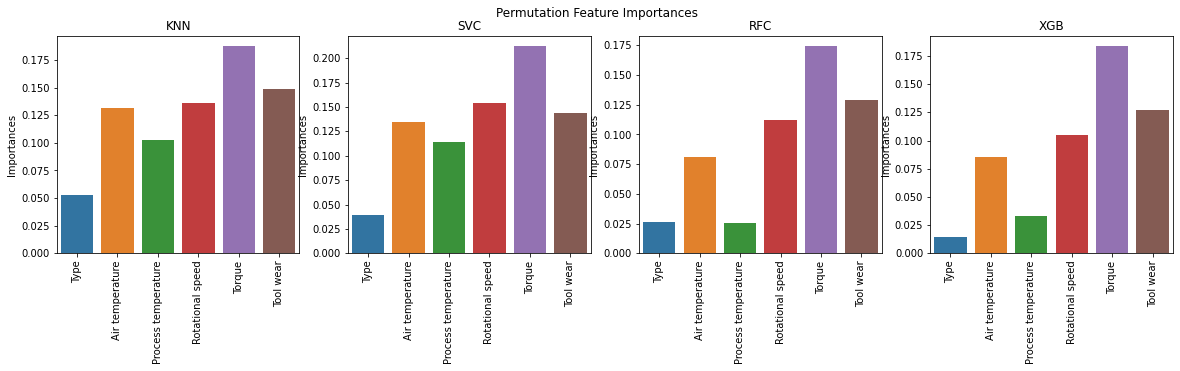

In [32]:
# Evaluate Permutation Feature Importances
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
importances = pd.DataFrame()
for clf in fitted_models_multi:
    result = permutation_importance(clf, X_train,y_train['Failure Type'],
                                  scoring=f2_scorer,random_state=0)
    result_mean = pd.Series(data=result.importances_mean, index=X.columns)
    importances = pd.concat(objs=[importances,result_mean],axis=1)

importances.columns = clf_str

# Barplot of Feature Importances
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
fig.suptitle('Permutation Feature Importances')
for j, name in enumerate(importances.columns):
    sns.barplot(ax=axs[j], x=importances.index, y=importances[name].values)
    axs[j].tick_params('x',labelrotation=90)
    axs[j].set_ylabel('Importances')
    axs[j].title.set_text(str(name))
plt.show()

From previous barplots we see that the models give more importance to Torque, Tool wear
and Rotational Speed while the Type contribution is very low. This is in accordance with the
observations made in the exploration of the dataset in Section 1-2 and it is consistent with the
Permutation Feature Importances of binary task.
K-NN is the one who gives more importance to Type, but, different from binary case, here we
see that for every model the Type contribution is almost zero. So, we test the model on a new
dataset, the old one from which we removed the column Type. For K-NN and SVC there is an
insignificant improvement in the metrics’ values, which were already very good. For RFC and XGB we do not see any change on metrics’ values. Since the training time for the different models
is approximately equal in both cases, we let users choose which dataset to use.

## 5) **Decision Paths** <a id="decisionpath"></a>

Here we show the decision paths of one of the trees that make up the Random Forest for both
tasks, truncated at depth=4. However this depth is enough to verify that trees require to be
deep because the decision boundary are complex themselves and they are not overfitting. This
is evident if one looks at the multi-class tree, where some kinds of failure do not appear before
depth four, but also in the binary classification tree by looking at the evolution of the gini score
while following most of the paths. A further remark can be made about the feature Type being
the origin node of both graphs and separating the majority class (Low quality) from the other
two at the first step. It appears just one time more in the upper side of the trees and shows
sporadically again at the lowest floors, where its impact is scarce.

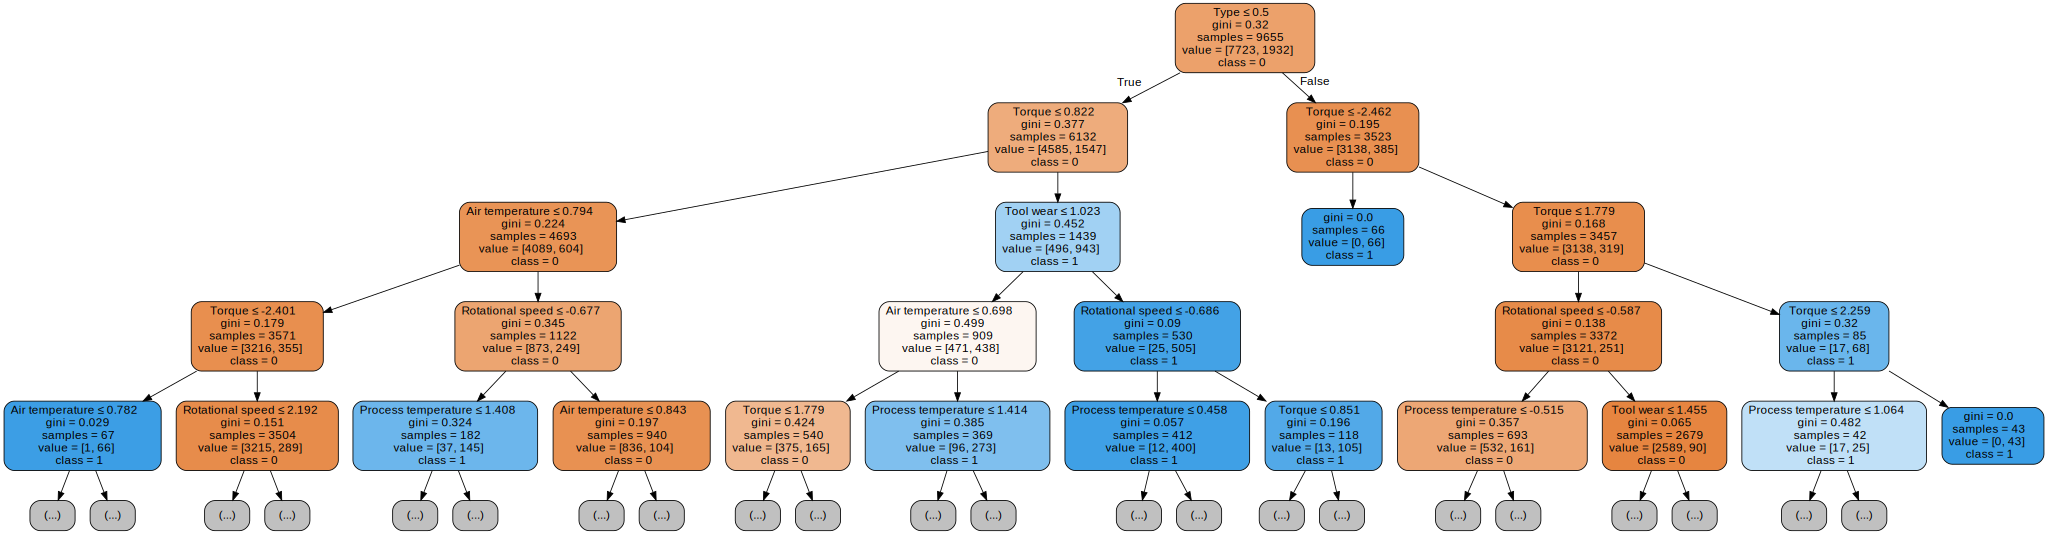

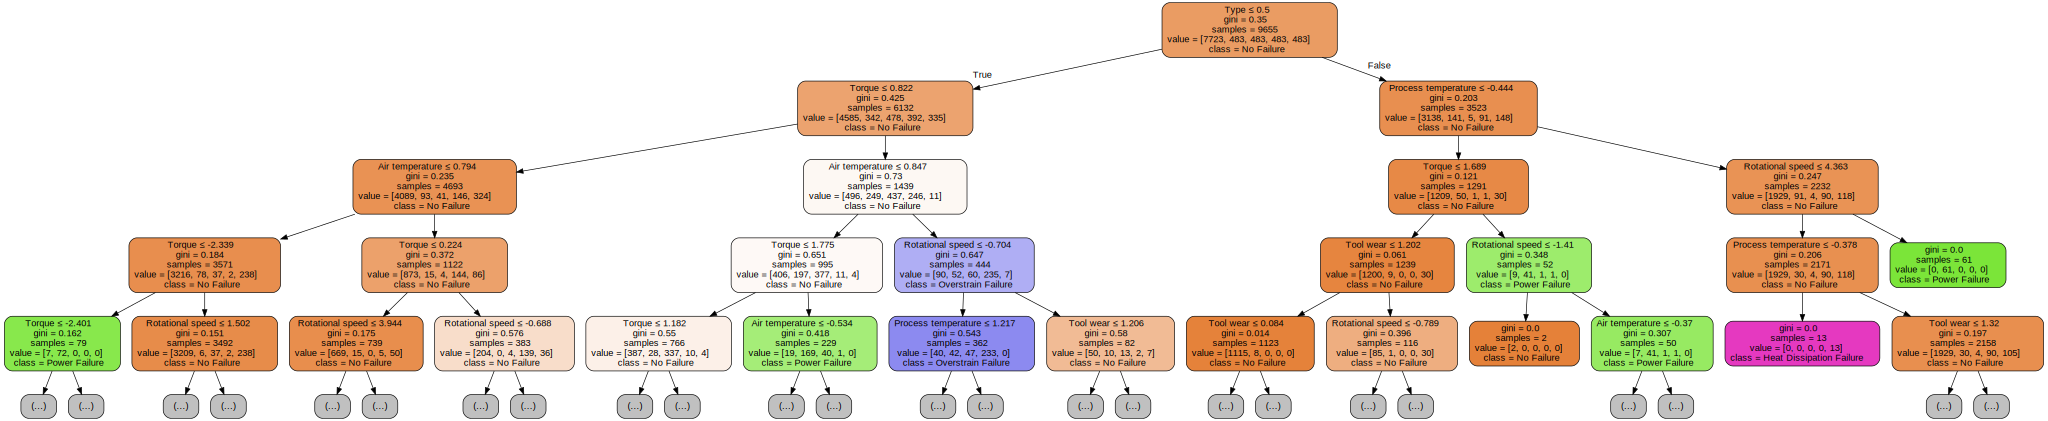

In [33]:
# Random Forest Decision Path
from sklearn import tree
import graphviz

tree_binary = fitted_models_binary[2].best_estimator_.estimators_[0]
tree_multi = fitted_models_multi[2].best_estimator_.estimators_[0]
trees = [tree_binary,tree_multi]
targets = ['Target', 'Failure Type']
for decision_tree, target in zip(trees, targets):
    decision_tree.fit(X_train,y_train[target])
    classes = list(map(str,df_res[target].unique()))

    dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                  feature_names=X.columns,  
                                  class_names=classes,
                                  filled=True, rounded=True,  
                                  special_characters=True,
                                  max_depth=4)  # uncomment to see full tree
    graph = graphviz.Source(dot_data)
    graph.render(target+" Classification tree")
    display(graph)

## 6) **Conclusions** <a id="conclusions"></a>

According to the analyses carried out and the results obtained, it is possible to make some
conclusive considerations related to this project.

We decided to tackle two tasks: predict whether a machine will fail or not and predict the type
of failure that will occur. Before developing the models we did data preprocessing to ensure the
validity of the assumptions of applicability of the models and ensure the best performances.
Briefly, in preprocessing phase we have deleted some ambiguous samples, we applied a label
encoding to the categorical columns and then we performed the scaling of the columns with
StandardScaler. We also noticed the presence of some data points which at first we referred
as outliers but later turned out to be part of the natural variance of the data and played an
important role in the classification task. Then we ran PCA and found that most of the variance
is explained by the first three components, that can be represented as the following features:
combination of the two Temperatures, Machine Power (product of Rotational Speed and Torque)
and Tool Wear. In according to this, we found that these are the features that contribute the
most in the predictions when apply the models. Contrary to logical predictions, we demonstrated
that the machine’s type does not affect the presence of failure.

At the end, we can conclude that for both task the chosen models perform very well. For both
tasks the best model is XGBoost and the worst is KNN; however the response time of KNN
is instant while XGBoost takes more time and this further increase when we proceed with the
multi-class classification task. The choice of the model depends on the needs of the company: for
faster application one can use KNN while if one cares more about accuracy one can use XGBoost.